Our objective is to make a 6 weeks sales prediction for 1115 Rossmann stores. We will do data cleaning and EDA. In a first step, we will apply univariate time series and fit a model to each store and we will see how far we come with only the sales data. After that, we will use feature engineering to apply advanced supervised learning algorithms.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import datetime

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns # advanced vizs
%matplotlib inline


##### Short description:
- Sales: the turnover for any given day (target variable).
- Customers: the number of customers on a given day.
- Open: an indicator for whether the store was open: 0 = closed, 1 = open.
- Promo: indicates whether a store is running a promo on that day.
- StateHoliday: indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. 
- SchoolHoliday: indicates if the (Store, Date) was affected by the closure of public schools.

In [3]:
# Load data
train = pd.read_csv("/Users/manueloers/Downloads/rossmann-store-sales/train.csv", low_memory=False, index_col="Date", parse_dates=True)
test = pd.read_csv("/Users/manueloers/Downloads/rossmann-store-sales/test.csv", index_col="Date", parse_dates=True)
store = pd.read_csv("/Users/manueloers/Downloads/rossmann-store-sales/store.csv")

# Shape of each dataset
print("The train dataset has the following shape:", train.shape)
print("The test dataset has the following shape:", test.shape)
print("The store dataset has the following shape:", store.shape)

# Lets look at the first 5 row of the train dataset
print("\nThe first 5 rows of the train dataset:")
train.head()

The train dataset has the following shape: (1017209, 8)
The test dataset has the following shape: (41088, 7)
The store dataset has the following shape: (1115, 10)

The first 5 rows of the train dataset:


,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1
2015-07-31,2,5,6064,625,1,1,0,1
2015-07-31,3,5,8314,821,1,1,0,1
2015-07-31,4,5,13995,1498,1,1,0,1
2015-07-31,5,5,4822,559,1,1,0,1


In [4]:
print(train.index)
print("\nThe train dataset consists of daily sales data for 1115 Rossmann stores from 01/01/2013 to 07/31/2015\n")
print(test.index)
print("\nThe test dataset covers the following 6 weeks.")

DatetimeIndex(['2015-07-31', '2015-07-31', '2015-07-31', '2015-07-31',
               '2015-07-31', '2015-07-31', '2015-07-31', '2015-07-31',
               '2015-07-31', '2015-07-31',
               ...
               '2013-01-01', '2013-01-01', '2013-01-01', '2013-01-01',
               '2013-01-01', '2013-01-01', '2013-01-01', '2013-01-01',
               '2013-01-01', '2013-01-01'],
              dtype='datetime64[ns]', name='Date', length=1017209, freq=None)

The train dataset consists of daily sales data for 1115 Rossmann stores from 01/01/2013 to 07/31/2015

DatetimeIndex(['2015-09-17', '2015-09-17', '2015-09-17', '2015-09-17',
               '2015-09-17', '2015-09-17', '2015-09-17', '2015-09-17',
               '2015-09-17', '2015-09-17',
               ...
               '2015-08-01', '2015-08-01', '2015-08-01', '2015-08-01',
               '2015-08-01', '2015-08-01', '2015-08-01', '2015-08-01',
               '2015-08-01', '2015-08-01'],
              dtype='datetime64[ns]', 

In [5]:
test.head()

,Id,Store,DayOfWeek,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,
2015-09-17,1,1,4,1.0,1,0,0
2015-09-17,2,3,4,1.0,1,0,0
2015-09-17,3,7,4,1.0,1,0,0
2015-09-17,4,8,4,1.0,1,0,0
2015-09-17,5,9,4,1.0,1,0,0


In the test data, we don't have the target variable as well as the "Customers" variable. That is, why we drop the test set and split the train set for validation purposes.

In [122]:
del test

In [400]:
# Number of unique Stores in the train dataset
print(train["Store"].nunique())

print(f"In the train dataset we are dealing with {train.shape[0]} entries and {train.shape[1]} features.")

1115
In the train dataset we are dealing with 1017209 entries and 11 features.


### Handling Missing Values

In [401]:
train.isnull().sum()

Store            0
DayOfWeek        0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
Year             0
Month            0
Day              0
dtype: int64

In [403]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1017209 entries, 2015-07-31 to 2013-01-01
Data columns (total 11 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Sales          1017209 non-null  int64 
 3   Customers      1017209 non-null  int64 
 4   Open           1017209 non-null  int64 
 5   Promo          1017209 non-null  int64 
 6   StateHoliday   1017209 non-null  object
 7   SchoolHoliday  1017209 non-null  int64 
 8   Year           1017209 non-null  int64 
 9   Month          1017209 non-null  int64 
 10  Day            1017209 non-null  int64 
dtypes: int64(10), object(1)
memory usage: 93.1+ MB


### Checking for Correlations

The main approach in this notebook will be to use univariate time series models and for that reason we are for now only interested features that correlate the most with the target variable which are "Open" and "Promo". The "Open" varibale will be used as an indicator for holidays and the "Promo" variable as an additional exogeneous variable which the SARIMA models allows us to use as an input. Let's check if the entries for "Sales" and "Open", "Promo" dont have strange entries.

<AxesSubplot:xlabel='Date'>

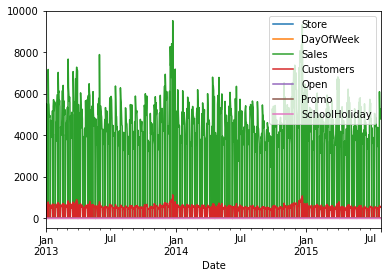

In [128]:
train[(train.Store == 1)].plot()

In [129]:
corr_matrix = train.corr()

In [130]:
corr_matrix

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday
Store,1.000000,-0.000008,0.005126,0.024325,-0.000047,0.000058,0.000641
DayOfWeek,-0.000008,1.000000,-0.462125,-0.386445,-0.528963,-0.392925,-0.205388
Sales,0.005126,-0.462125,1.000000,0.894711,0.678472,0.452345,0.085124
Customers,0.024325,-0.386445,0.894711,1.000000,0.616768,0.316169,0.071568
Open,-0.000047,-0.528963,0.678472,0.616768,1.000000,0.295042,0.086171
Promo,0.000058,-0.392925,0.452345,0.316169,0.295042,1.000000,0.067483
SchoolHoliday,0.000641,-0.205388,0.085124,0.071568,0.086171,0.067483,1.000000


In [131]:
corr_matrix["Sales"]

Store            0.005126
DayOfWeek       -0.462125
Sales            1.000000
Customers        0.894711
Open             0.678472
Promo            0.452345
SchoolHoliday    0.085124
Name: Sales, dtype: float64

We will not use "Customer" because in real out-of-sample forecast we would not know the true number of customers.

In [126]:
print(train["Sales"].value_counts())
print(train["Open"].value_counts())
print(train["Promo"].value_counts())
print(train["DayOfWeek"].value_counts())

0        172871
5674        215
5558        197
5483        196
6049        195
          ...  
32605         1
24275         1
26167         1
17971         1
22905         1
Name: Sales, Length: 21734, dtype: int64
1    844392
0    172817
Name: Open, dtype: int64
0    629129
1    388080
Name: Promo, dtype: int64
5    145845
4    145845
3    145665
2    145664
7    144730
6    144730
1    144730
Name: DayOfWeek, dtype: int64


Looks good!

In [149]:
train_s1 = train[(train.Store == 2)]

In [150]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series):
    result=adfuller(series)
    print('ADF Statistics: {}'.format(result[0]))
    print('p- value: {}'.format(result[1]))
    if result[1] <= 0.05:
        print("There is strong evidence against the null hypothesis. According to the Dickey-Fuller-Test we have a stationary series.")
    else:
        print("There is weak evidence against the null hypothesis which indicates that the time series has a unit root and is non-stationary ")



adf_test(train_s1['Sales'])

ADF Statistics: -6.218236994150317
p- value: 5.300862570846192e-08
There is strong evidence against the null hypothesis. According to the Dickey-Fuller-Test we have a stationary series.


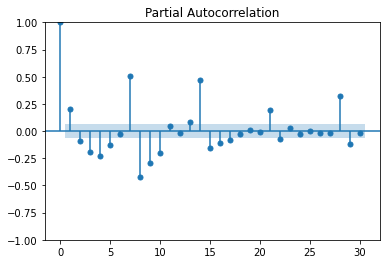

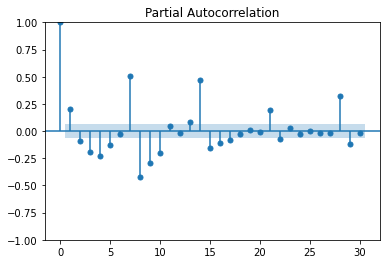

In [151]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

plot_pacf(train_s1["Sales"])


We see a significant lag at every 7th lag indicating that the sales target variable is strongly seasonal.

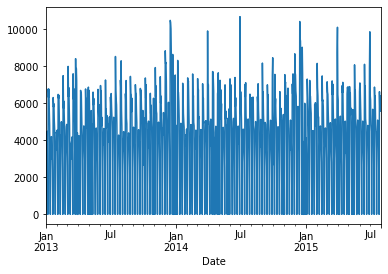

In [152]:
train_s1["Sales"].plot()
test_s1 = train_s1.iloc[:49]
test_s1 = test_s1.copy()
train_s1 = train_s1.iloc[49:]

### Persistence Model

      t-1   t+1
0     NaN  3539
1  3539.0  4240
2  4240.0  5035
3  5035.0  4097
4  4097.0  3918
Test RMSE: 2826.083


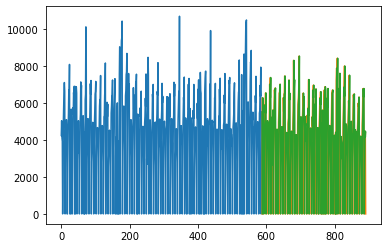

In [188]:
# Data
series = train_s1["Sales"]

# Create lagged dataset
values = pd.DataFrame(series.values)
dataframe = pd.concat([values.shift(1), values], axis=1)
dataframe.columns = ['t-1', 't+1']
print(dataframe.head(5))


# split into train and test sets
X = dataframe.values
train_size = int(len(X) * 0.66)
train_per, test_per = X[1:train_size], X[train_size:]
train_X_per, train_y_per = train_per[:,0], train_per[:,1]
test_X_per, test_y_per = test_per[:,0], test_per[:,1]

# persistence model
def model_persistence(x):
	return x

# walk-forward validation
predictions = list()
for x in test_X_per:
	yhat = model_persistence(x)
	predictions.append(yhat)
test_score = np.sqrt(mean_squared_error(test_y_per, predictions))
print('Test RMSE: %.3f' % test_score)

# plot predictions and expected results
plt.plot(train_y_per)
plt.plot([None for i in train_y_per] + [x for x in test_y_per])
plt.plot([None for i in train_y_per] + [x for x in predictions])
plt.show()

### Model Training

/Users/manueloers/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  self._init_dates(dates, freq)
/Users/manueloers/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/manueloers/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  self._init_dates(dates, freq)
/Users/manueloers/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, 

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.42166D+00    |proj g|=  2.44834D-02

At iterate    5    f=  8.40038D+00    |proj g|=  5.94165D-03

At iterate   10    f=  8.39776D+00    |proj g|=  4.38250D-04

At iterate   15    f=  8.39736D+00    |proj g|=  2.37709D-03

At iterate   20    f=  8.13433D+00    |proj g|=  3.60931D-01

At iterate   25    f=  7.94992D+00    |proj g|=  1.43198D-03

At iterate   30    f=  7.94886D+00    |proj g|=  4.45539D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

/Users/manueloers/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


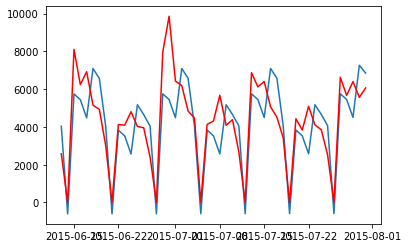

In [192]:
from codecs import ignore_errors
from statsmodels.tsa.statespace.sarimax import SARIMAX
model_SARIMA=SARIMAX(train_s1["Sales"],order=(0,0,2),seasonal_order=(0,2,2,7), exog=train_s1[["Open", "Promo"]], ignore_errors=True)
model_SARIMA_fit=model_SARIMA.fit(ignore_errors=True)

print(model_SARIMA_fit.summary())
pred = pred_Sarima=model_SARIMA_fit.forecast(steps=49, exog=test_s1[["Open", "Promo"]])
pred.index = test_s1.index
pred
plt.plot(pred)
plt.plot(test_s1["Sales"], color="Red")

Amazing how our model predict 6 weeks ahead by only using the recursive strategy.

<AxesSubplot:xlabel='Date'>

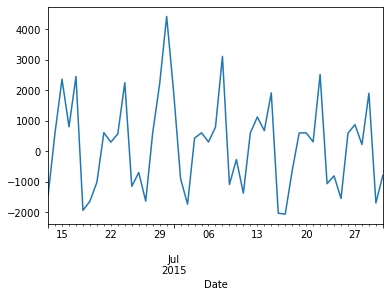

In [193]:
resid = test_s1["Sales"] - pred
resid.plot()

We can see that there still potential. The model has not caught the entire seasonality.

<AxesSubplot:ylabel='Density'>

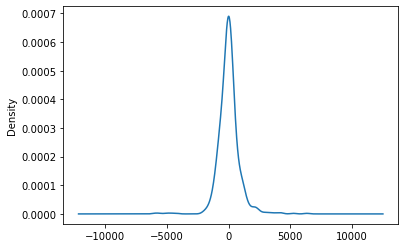

In [190]:
model_SARIMA_fit.resid.plot(kind="kde")

In [191]:
from sklearn.metrics import mean_squared_error
print(f'The RMSE is {np.sqrt(mean_squared_error(tes1["Sales"], pred))}')

The RMSE is 856.0783171327009


The RMSE is not satisfying but a lot better than the persistence model's RMSE. 

In [221]:
# grid search sarima hyperparameters for monthly mean temp dataset
from math import sqrt
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from pandas import read_csv

# one-step sarima forecast
def sarima_forecast(history, config, exog):
	order, sorder, trend = config, exog = exog_values
	# define model
	model = SARIMAX(history, order=order, seasonal_order=sorder, trend=trend, enforce_stationarity=False, enforce_invertibility=False, exog=exog)
	# fit model
	model_fit = model.fit(disp=False)
	# make one step forecast
	yhat = model_fit.predict(len(history), len(history), len(history))
	return yhat[0]

# root mean squared error or rmse
def measure_rmse(actual, predicted):
	return sqrt(mean_squared_error(actual, predicted))

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test], data[-n_test:]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg, exog):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test, exog)
		# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# fit model and make forecast for history
		yhat = sarima_forecast(history, cfg, exog)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
	# estimate prediction error
	error = measure_rmse(test, predictions)
	return error

# score a model, return None on failure
def score_model(data, n_test, cfg, debug=False):
	result = None
	# convert config to a key
	key = str(cfg)
	# show all warnings and fail on exception if debugging
	if debug:
		result = walk_forward_validation(data, n_test, cfg)
	else:
		# one failure during model validation suggests an unstable config
		try:
			# never show warnings when grid searching, too noisy
			with catch_warnings():
				filterwarnings("ignore")
				result = walk_forward_validation(data, n_test, cfg)
		except:
			error = None
	# check for an interesting result
	if result is not None:
		print(' > Model[%s] %.3f' % (key, result))
	return (key, result)

# grid search configs
def grid_search(data, cfg_list, n_test, parallel=True):
	scores = None
	if parallel:
		# execute configs in parallel
		executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing')
		tasks = (delayed(score_model)(data, n_test, cfg) for cfg in cfg_list)
		scores = executor(tasks)
	else:
		scores = [score_model(data, n_test, cfg) for cfg in cfg_list]
	# remove empty results
	scores = [r for r in scores if r[1] != None]
	# sort configs by error, asc
	scores.sort(key=lambda tup: tup[1])
	return scores

# create a set of sarima configs to try
def sarima_configs(seasonal=[0]):
	models = list()
	# define config lists
	p_params = [0, 1, 2]
	d_params = [0, 1]
	q_params = [0, 1, 2]
	t_params = ['n','c','t','ct']
	P_params = [0, 1, 2]
	D_params = [0, 1]
	Q_params = [0, 1, 2]
	m_params = seasonal
	# create config instances
	for p in p_params:
		for d in d_params:
			for q in q_params:
				for t in t_params:
					for P in P_params:
						for D in D_params:
							for Q in Q_params:
								for m in m_params:
									cfg = [(p,d,q), (P,D,Q,m), t]
									models.append(cfg)
	return models

if __name__ == '__main__':
	# load dataset
	series = train_s1["Sales"]
	data = series.values
	exog_values=train_s1[["Open", "Promo"]].values
	# data split
	n_test = 7
	# model configs
	cfg_list = sarima_configs(seasonal=[7])
	# grid search
	scores = grid_search(data, cfg_list, n_test)
	print('done')
	# list top 3 configs
	for cfg, error in scores[:3]:
		print(cfg, error)


: 